In [172]:
%matplotlib inline
import pandas as pd
import datetime as dt
import numpy as np
import json
import itertools
import matplotlib.pyplot as plt
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()

In [98]:
# load json as string
logins = json.load((open('logins.json')))
log_df = pd.DataFrame(logins)


log_df['login_time'] = log_df['login_time'].astype('datetime64[ns]')
log_df2 = log_df.sort_values(by='login_time')
log_df2.head()

,login_time
6,1970-01-01 20:12:16
0,1970-01-01 20:13:18
1,1970-01-01 20:16:10
3,1970-01-01 20:16:36
2,1970-01-01 20:16:37


In [99]:
log_df2.describe()

,login_time
count,93142
unique,92265
top,1970-04-04 01:17:40
freq,3
first,1970-01-01 20:12:16
last,1970-04-13 18:57:38


It is interesting to note here that we have only 92265 unique values so we have login_times that are duplicated. There is also at least one time that shows up 3 times in the column. I assume this is due to the fact that there are multiple users listed that logged in at the same time. 

In [52]:
log_df2[log_df2['login_time'] == '1970-02-12 11:16:53']

,login_time
29797,1970-02-12 11:16:53
29774,1970-02-12 11:16:53
29790,1970-02-12 11:16:53


In [124]:
log_df3 = log_df2.copy()
log_df3.set_index('login_time',inplace=True)
log_df3['count']=1
log_df3.head()

,count
login_time,
1970-01-01 20:12:16,1
1970-01-01 20:13:18,1
1970-01-01 20:16:10,1
1970-01-01 20:16:36,1
1970-01-01 20:16:37,1


In [263]:
date1 = log_df3.index[0]
date2 = log_df3.index[-1]
date2-date1 #101 days 22:45:00

Timedelta('101 days 22:45:00')

In [269]:
#checking to see if there were any days that were not recorded from the beginning to the end. It doesn't skip
# any days either as seen by 103 with the timedelta above being 101 days and 22:45:00. It starts at 20:00:00 
# and ends with less than a day at the end which is why summing the days will provide 103 separate days, but 
# the time delta only being 101
days = log_df3.resample('D').sum()
print(len(days))
days[days['count']==0]

103


,count
login_time,


In [138]:
log_df3 = log_df3.resample('15T').sum()
print(log_df3.describe())
log_df3.head()

             count
count  9788.000000
mean      9.515938
std       8.328818
min       0.000000
25%       3.000000
50%       7.000000
75%      13.000000
max      73.000000


,count
login_time,
1970-01-01 20:00:00,2
1970-01-01 20:15:00,6
1970-01-01 20:30:00,9
1970-01-01 20:45:00,7
1970-01-01 21:00:00,1


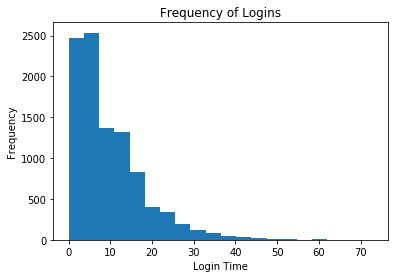

In [213]:
plt.hist(log_df3['count'], bins=20)
plt.xlabel('Login Time')
plt.ylabel('Frequency')
plt.title('Frequency of Logins')
plt.show()

Besides the skew and the repetition of login times, it appears that the data is fairly high quality so far, without looking at any of the other metrics. 

A majority of 15 minute intervals have on average 9 logins, with a median of 7; however, as the histogram depicts, the data is highly skewed, with over 5000 15 minute periods between 0-10 logins. Looking further into the data. There are 407 15-min intervals where there are no logins at all. Below I analyze the daily rythem of these logins. 

In [192]:
def login_time_series(df, samplemin, samplemax, timeinterval='15T'):
    """this function takes a dataframe with a datetime index and takes out a subset of the dataframe given the 
    sample minimum and maximum index values. It also resamples based upon the provided timeinterval. Default 
    is every 15 minutes.
    """
    df2 = df.resample(timeinterval).sum()
    subset = df2.iloc[samplemin:samplemax]
    _= plt.figure(figsize=(18,16), dpi=80,facecolor='w',edgecolor='k')
    _= plt.plot(subset.index, subset['count'])
    _= plt.xlim((subset.index[0],subset.index[-1]))
    _= plt.xticks(rotation='vertical')
    return(plt.show())

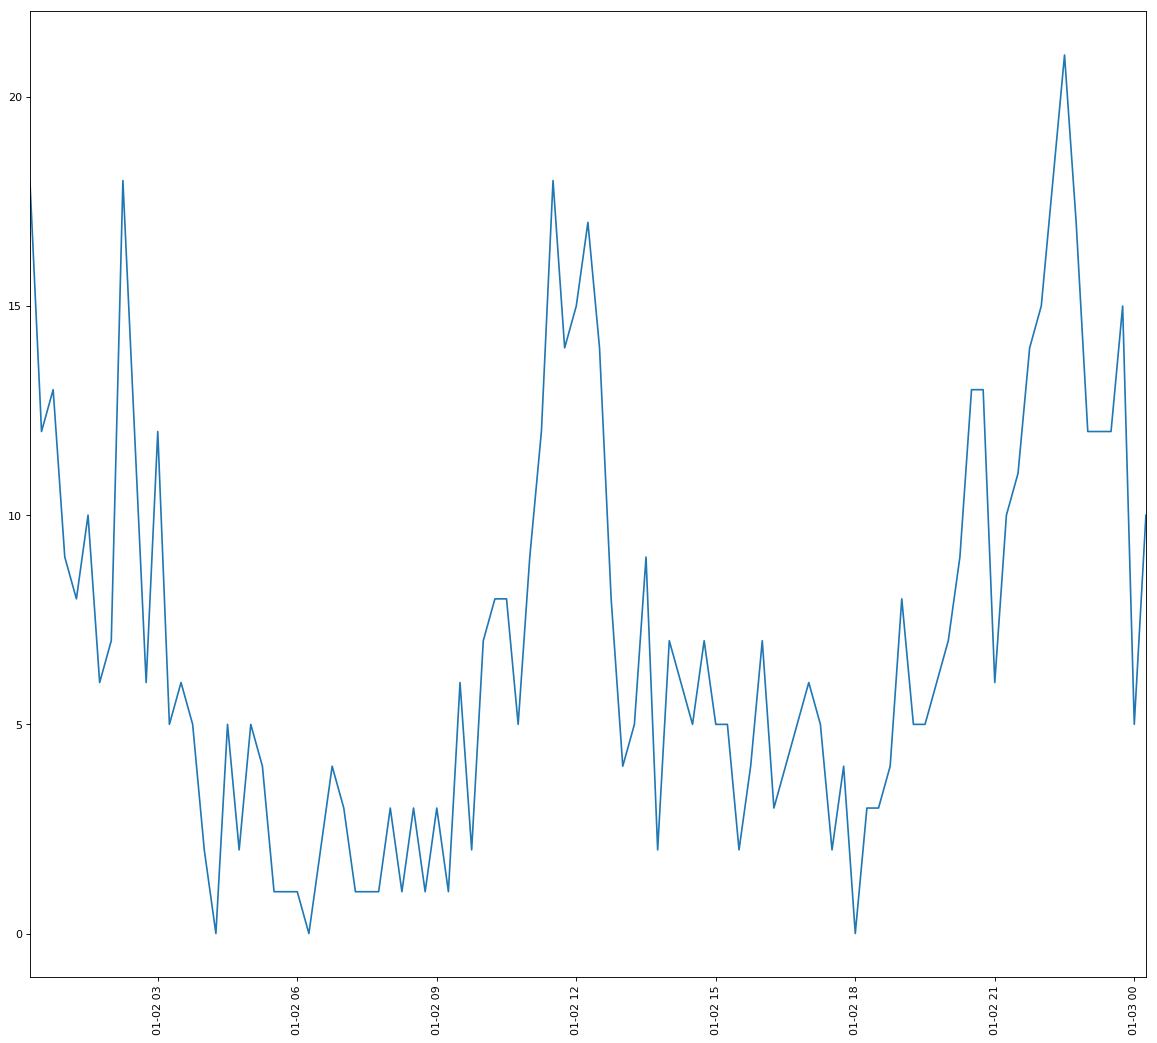

In [203]:
# interval is every 15 minutes taken over the 1st full day. 
login_time_series(log_df3,17, 114, timeinterval='15T')

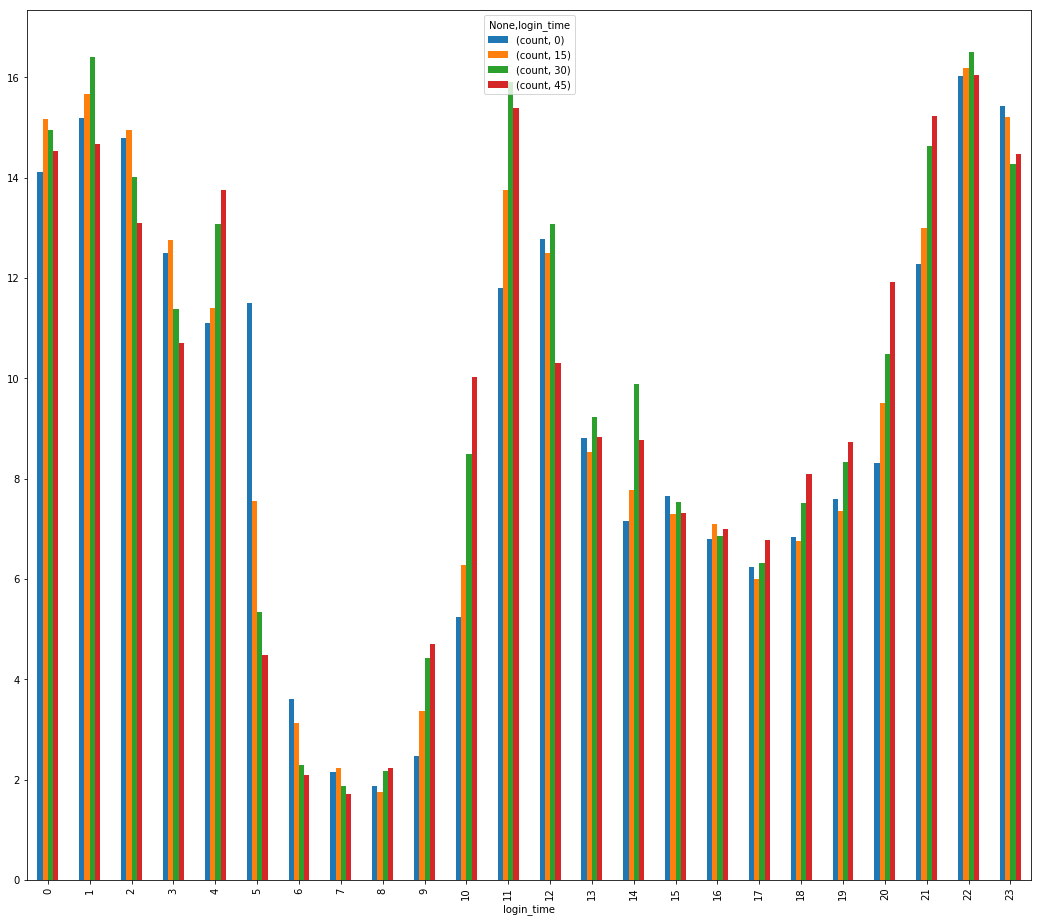

In [233]:
# this figure shows the average for each 15 minute time interval the number of logins over that time interval
# each day. I'm not exactly sure what type of logins these are meant to simulate but it appears that people 
# are logging on at night and during their lunch break, but are not logging on during the work hours. 
daily_avg = log_df3.groupby([log_df3.index.hour,log_df3.index.minute]).mean()
_= daily_avg.unstack(level=1).plot(kind='bar', figsize=(18,16))
_=plt.show()
